In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import itertools

In [2]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()


,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447542,10588.793237,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214032,25047.188462,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212376,50797.690402,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130084,74999.343414,360.000000,7.799086,16.421115,7.252319


In [3]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [4]:
#counting
weather_counts = df['SYNOPCode'].value_counts()
print(weather_counts)

0    56964
6    25018
5     6605
8     1716
4      466
7      419
3      191
Name: SYNOPCode, dtype: int64


In [5]:
#stratified sampling trainset
X_synop_0 = X_train[X_train['SYNOPCode'] == 0]
y_synop_0_FSO = y_FSO_train[X_synop_0.index]
y_synop_0_RFL = y_RFL_train[X_synop_0.index]
# group trainset by Distance, time and Frequency
# create an empty list to save sample
sampled_X = []
sampled_y_FSO = []
sampled_y_RFL = []
#stratified sampling X
sampled_X=X_synop_0.groupby(['Distance','Frequency','Time'], group_keys=False).apply(
    lambda group:group.sample(n=min(5, len(group)), random_state=42)
)
#make Y correspond to X
sampled_y_FSO=y_synop_0_FSO.loc[sampled_X.index]
sampled_y_RFL=y_synop_0_RFL.loc[sampled_X.index]
#delete synop_0 data in the trainset
X_no_synop_0 = X_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_FSO_no_synop_0 = y_FSO_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
y_RFL_no_synop_0 = y_RFL_train[X_train['SYNOPCode'] != 0].reset_index(drop=True)
#merge data with deleted trainest and sampled synop_0 trainset data
X_combined = pd.concat([X_no_synop_0, sampled_X], ignore_index=True)
y_FSO_combined = pd.concat([y_FSO_no_synop_0, sampled_y_FSO], ignore_index=True)
y_RFL_combined = pd.concat([y_RFL_no_synop_0, sampled_y_RFL], ignore_index=True)
#redistribute data
combined = pd.concat([X_combined, y_FSO_combined, y_RFL_combined], axis=1)
shuffled_combined = combined.sample(frac=1, random_state=42).reset_index(drop=True)
X_train = shuffled_combined.iloc[:, :-2]
y_FSO_train = shuffled_combined.iloc[:, -2]
y_RFL_train = shuffled_combined.iloc[:, -1]

In [6]:
if (X_no_synop_0.index == y_FSO_no_synop_0.index).all():
    print("X 和 Y 索引一致")
else:
    print("X 和 Y 索引不一致")

X 和 Y 索引一致


In [7]:
if (X_train.index == y_RFL_train.index).all():
    print("X 和 Y 索引一致")
else:
    print("X 和 Y 索引不一致")

X 和 Y 索引一致


In [8]:


# Generate interaction terms
def create_interaction_terms(df, features):
    interaction_data = df.copy()
    for feat1, feat2 in itertools.combinations(features, 2):
        interaction_name = f"{feat1}_x_{feat2}"
        interaction_data[interaction_name] = df[feat1] * df[feat2]
    return interaction_data

# 定义用于每个模型的变量列表
variables = {
    'Overall_FSO_Att': ['VisibilityMin', 'ParticulateMin', 'Temperature', 'Visibility', 'Distance'],
    'Overall_RFL_Att': ['RainIntensityMax', 'Distance', 'RainIntensity', 'AbsoluteHumidity'],
    'SynopCode_0_FSO_Att': ['AbsoluteHumidity', 'Visibility', 'Temperature', 'Distance'],
    'SynopCode_0_RFL_Att': ['Frequency', 'Visibility', 'AbsoluteHumidityMax', 'Temperature', 'AbsoluteHumidity', 'Distance'],
    'SynopCode_3_FSO_Att': ['RelativeHumidity', 'Time', 'VisibilityMax', 'Visibility', 'Distance', 'VisibilityMin'],
    'SynopCode_3_RFL_Att': ['TemperatureDifference', 'TemperatureMin', 'AbsoluteHumidityMax', 'TemperatureMax', 'Time', 'AbsoluteHumidityMin'],
    'SynopCode_4_FSO_Att': ['Visibility', 'TemperatureMin', 'Distance', 'ParticulateMin', 'Temperature', 'Particulate', 'ParticulateMax'],
    'SynopCode_4_RFL_Att': ['RainIntensity', 'RelativeHumidity'],
    'SynopCode_5_FSO_Att': ['Temperature', 'Visibility', 'ParticulateMax', 'Distance'],
    'SynopCode_5_RFL_Att': ['RainIntensityMax', 'Distance', 'AbsoluteHumidityMin', 'AbsoluteHumidityMax', 'AbsoluteHumidity'],
    'SynopCode_6_FSO_Att': ['Visibility', 'Temperature', 'ParticulateMax', 'Distance', 'Particulate'],
    'SynopCode_6_RFL_Att': ['Distance', 'Visibility', 'RainIntensityMax', 'AbsoluteHumidity', 'RainIntensity'],
    'SynopCode_7_FSO_Att': ['TemperatureDifference', 'Temperature', 'ParticulateMin', 'ParticulateMax', 'Particulate'],
    'SynopCode_7_RFL_Att': ['TemperatureDifference', 'Time', 'RainIntensityMin', 'WindSpeedMax'],
    'SynopCode_8_FSO_Att': ['AbsoluteHumidity', 'Distance', 'Visibility'],
    'SynopCode_8_RFL_Att': ['VisibilityMin', 'RainIntensityMin', 'AbsoluteHumidityMax', 'RainIntensity', 'AbsoluteHumidity']
}

# 创建交互项
for synop_code in [0, 3, 4, 5, 6, 7, 8]:
    # 按照SynopCode进行训练集数据提取
    X_train_synop = X_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
    X_test_synop = X_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
    
    # 获取对应的 y 数据集
    y_FSO_train_synop = y_FSO_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
    y_RFL_train_synop = y_RFL_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
    y_FSO_test_synop = y_FSO_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
    y_RFL_test_synop = y_RFL_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
    
    # 获取SynopCode对应的特征集
    fso_features = variables[f'SynopCode_{synop_code}_FSO_Att']
    rfl_features = variables[f'SynopCode_{synop_code}_RFL_Att']
    
    # 为FSO和RFL模型生成训练集的交互项
    X_train_fso_interactions = create_interaction_terms(X_train_synop, fso_features)
    X_train_rfl_interactions = create_interaction_terms(X_train_synop, rfl_features)
    
    # 为FSO和RFL模型生成测试集的交互项
    X_test_fso_interactions = create_interaction_terms(X_test_synop, fso_features)
    X_test_rfl_interactions = create_interaction_terms(X_test_synop, rfl_features)
    
    # 为每个SynopCode生成唯一的变量，避免覆盖，并保持y数据集与X数据集对应
    globals()[f"X_train_fso_synop_{synop_code}"] = X_train_fso_interactions
    globals()[f"X_train_rfl_synop_{synop_code}"] = X_train_rfl_interactions
    globals()[f"X_test_fso_synop_{synop_code}"] = X_test_fso_interactions
    globals()[f"X_test_rfl_synop_{synop_code}"] = X_test_rfl_interactions
    
    globals()[f"y_FSO_train_synop_{synop_code}"] = y_FSO_train_synop
    globals()[f"y_RFL_train_synop_{synop_code}"] = y_RFL_train_synop
    globals()[f"y_FSO_test_synop_{synop_code}"] = y_FSO_test_synop
    globals()[f"y_RFL_test_synop_{synop_code}"] = y_RFL_test_synop
    
    # 输出数据集大小以确保操作成功
    print(f"SynopCode {synop_code}: FSO Train Shape {X_train_fso_interactions.shape}, RFL Train Shape {X_train_rfl_interactions.shape}")
    print(f"SynopCode {synop_code}: FSO Test Shape {X_test_fso_interactions.shape}, RFL Test Shape {X_test_rfl_interactions.shape}")
    print(f"SynopCode {synop_code}: y_FSO Train Shape {y_FSO_train_synop.shape}, y_RFL Train Shape {y_RFL_train_synop.shape}")

# Overall FSO 和 RFL 模型的变量集
overall_fso_features = variables['Overall_FSO_Att']
overall_rfl_features = variables['Overall_RFL_Att']

# 分别为 FSO 和 RFL 模型创建交互项
X_train_fso_overall = create_interaction_terms(X_train, overall_fso_features)
X_train_rfl_overall = create_interaction_terms(X_train, overall_rfl_features)
X_test_fso_overall = create_interaction_terms(X_test, overall_fso_features)
X_test_rfl_overall = create_interaction_terms(X_test, overall_rfl_features)

# 确保对应的目标变量一致
y_FSO_train_overall = y_FSO_train.reset_index(drop=True)
y_RFL_train_overall = y_RFL_train.reset_index(drop=True)
y_FSO_test_overall = y_FSO_test.reset_index(drop=True)
y_RFL_test_overall = y_RFL_test.reset_index(drop=True)

# 输出 overall 数据集大小以确保操作成功
print(f"Overall FSO: Train Shape {X_train_fso_overall.shape}, Test Shape {X_test_fso_overall.shape}")
print(f"Overall RFL: Train Shape {X_train_rfl_overall.shape}, Test Shape {X_test_rfl_overall.shape}")
print(f"y_FSO Overall: Train Shape {y_FSO_train_overall.shape}, Test Shape {y_FSO_test_overall.shape}")
print(f"y_RFL Overall: Train Shape {y_RFL_train_overall.shape}, Test Shape {y_RFL_test_overall.shape}")

# 保存 overall 模型数据集
globals()["X_train_fso_overall"] = X_train_fso_overall
globals()["X_train_rfl_overall"] = X_train_rfl_overall
globals()["X_test_fso_overall"] = X_test_fso_overall
globals()["X_test_rfl_overall"] = X_test_rfl_overall

globals()["y_FSO_train_overall"] = y_FSO_train_overall
globals()["y_RFL_train_overall"] = y_RFL_train_overall
globals()["y_FSO_test_overall"] = y_FSO_test_overall
globals()["y_RFL_test_overall"] = y_RFL_test_overall

SynopCode 0: FSO Train Shape (45571, 31), RFL Train Shape (45571, 40)
SynopCode 0: FSO Test Shape (11393, 31), RFL Test Shape (11393, 40)
SynopCode 0: y_FSO Train Shape (45571,), y_RFL Train Shape (45571,)
SynopCode 3: FSO Train Shape (153, 40), RFL Train Shape (153, 40)
SynopCode 3: FSO Test Shape (38, 40), RFL Test Shape (38, 40)
SynopCode 3: y_FSO Train Shape (153,), y_RFL Train Shape (153,)
SynopCode 4: FSO Train Shape (373, 46), RFL Train Shape (373, 26)
SynopCode 4: FSO Test Shape (93, 46), RFL Test Shape (93, 26)
SynopCode 4: y_FSO Train Shape (373,), y_RFL Train Shape (373,)
SynopCode 5: FSO Train Shape (5284, 31), RFL Train Shape (5284, 35)
SynopCode 5: FSO Test Shape (1321, 31), RFL Test Shape (1321, 35)
SynopCode 5: y_FSO Train Shape (5284,), y_RFL Train Shape (5284,)
SynopCode 6: FSO Train Shape (20014, 35), RFL Train Shape (20014, 35)
SynopCode 6: FSO Test Shape (5004, 35), RFL Test Shape (5004, 35)
SynopCode 6: y_FSO Train Shape (20014,), y_RFL Train Shape (20014,)
SynopC

In [9]:
# #define feature selection function
def fs(trainX, trainy, testX, testy):
    # Initialize S as the set of all predictor variables
    features = trainX.columns.tolist()
    #  Initialize an empty table R
    result_table = pd.DataFrame(columns=['feature', 'RMSE', 'R2_score'])
    print('----start training----')
    while features:
        # Train a random forest with the current set of features
        rf = RandomForestRegressor(n_estimators=100, random_state=1874845, oob_score=True)
        rf.fit(trainX[features], trainy)
        
        # Calculate RMSE and R2 for the current random forest
        y_pred = rf.predict(testX[features])
        rmse = np.sqrt(mean_squared_error(testy, y_pred))
        r2 = r2_score(testy, y_pred)
        
        # Rank importance and find the least important feature
        importance = rf.feature_importances_
        importance_df = pd.DataFrame({'feature': features, 'importance': importance})
        importance_df = importance_df.sort_values(by='importance', ascending=True)
        least_important_feature = importance_df.iloc[0]['feature']
        
        # Remove the least important feature from S and log the results
        features.remove(least_important_feature)
        Feature_info = pd.DataFrame([{
            'feature': least_important_feature,
            'RMSE': rmse,
            'R2_score': r2
        }])

        # Concatenate the new row to the result table
        result_table = pd.concat([result_table, Feature_info], ignore_index=True)
        
        # Display progress
        tqdm.write(f"Removed: {least_important_feature}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return result_table



In [10]:
#define plot function
def plot_results(result_RFL, result_FSO, code):
    # Extract data from result_RFL
    features_RFL = result_RFL['feature']
    rmse_values_RFL = result_RFL['RMSE']
    r2_values_RFL = result_RFL['R2_score']

    # Extract data from result_FSO
    features_FSO = result_FSO['feature']
    rmse_values_FSO = result_FSO['RMSE']
    r2_values_FSO = result_FSO['R2_score']

    # Create the figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=False)

    # Plotting result_RFL
    ax1.plot(features_RFL, rmse_values_RFL, color='blue', marker='o', label='RMSE')
    ax1.set_xlabel('Features')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='x', rotation=90)
    ax1.grid(True)

    # Second y-axis for R² in result_RFL
    ax1_twin = ax1.twinx()
    ax1_twin.plot(features_RFL, r2_values_RFL, color='red', marker='x', label='R²')
    ax1_twin.set_ylabel('R²', color='red')
    ax1_twin.tick_params(axis='y', colors='red')
    ax1.set_title(f'SYNOP({code}) model RFL Feature Importance Analysis with Interaction')

    # Plotting result_FSO
    ax2.plot(features_FSO, rmse_values_FSO, color='blue', marker='o', label='RMSE')
    ax2.set_xlabel('Features')
    ax2.set_ylabel('RMSE', color='blue')
    ax2.tick_params(axis='x', rotation=90)
    ax2.grid(True)

    # Second y-axis for R² in result_FSO
    ax2_twin = ax2.twinx()
    ax2_twin.plot(features_FSO, r2_values_FSO, color='red', marker='x', label='R²')
    ax2_twin.set_ylabel('R²', color='red')
    ax2_twin.tick_params(axis='y', colors='red')
    ax2.set_title(f'SYNOP({code}) model FSO Feature Importance Analysis with Interaction')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()


In [11]:
#define process function
# 定义 process 函数
def process(code):
    if code == 'Generic':
        # 处理 overall 模型
        result_RFL = fs(X_train_rfl_overall, y_RFL_train_overall, X_test_rfl_overall, y_RFL_test_overall)
        result_FSO = fs(X_train_fso_overall, y_FSO_train_overall, X_test_fso_overall, y_FSO_test_overall)
        return result_RFL, result_FSO
    elif code == 0:
        # 处理 SynopCode 0
        result_RFL = fs(X_train_rfl_synop_0, y_RFL_train_synop_0, X_test_rfl_synop_0, y_RFL_test_synop_0)
        result_FSO = fs(X_train_fso_synop_0, y_FSO_train_synop_0, X_test_fso_synop_0, y_FSO_test_synop_0)
        return result_RFL, result_FSO
    elif code == 3:
        # 处理 SynopCode 3
        result_RFL = fs(X_train_rfl_synop_3, y_RFL_train_synop_3, X_test_rfl_synop_3, y_RFL_test_synop_3)
        result_FSO = fs(X_train_fso_synop_3, y_FSO_train_synop_3, X_test_fso_synop_3, y_FSO_test_synop_3)
        return result_RFL, result_FSO
    elif code == 4:
        # 处理 SynopCode 4
        result_RFL = fs(X_train_rfl_synop_4, y_RFL_train_synop_4, X_test_rfl_synop_4, y_RFL_test_synop_4)
        result_FSO = fs(X_train_fso_synop_4, y_FSO_train_synop_4, X_test_fso_synop_4, y_FSO_test_synop_4)
        return result_RFL, result_FSO
    elif code == 5:
        # 处理 SynopCode 5
        result_RFL = fs(X_train_rfl_synop_5, y_RFL_train_synop_5, X_test_rfl_synop_5, y_RFL_test_synop_5)
        result_FSO = fs(X_train_fso_synop_5, y_FSO_train_synop_5, X_test_fso_synop_5, y_FSO_test_synop_5)
        return result_RFL, result_FSO
    elif code == 6:
        # 处理 SynopCode 6
        result_RFL = fs(X_train_rfl_synop_6, y_RFL_train_synop_6, X_test_rfl_synop_6, y_RFL_test_synop_6)
        result_FSO = fs(X_train_fso_synop_6, y_FSO_train_synop_6, X_test_fso_synop_6, y_FSO_test_synop_6)
        return result_RFL, result_FSO
    elif code == 7:
        # 处理 SynopCode 7
        result_RFL = fs(X_train_rfl_synop_7, y_RFL_train_synop_7, X_test_rfl_synop_7, y_RFL_test_synop_7)
        result_FSO = fs(X_train_fso_synop_7, y_FSO_train_synop_7, X_test_fso_synop_7, y_FSO_test_synop_7)
        return result_RFL, result_FSO
    elif code == 8:
        # 处理 SynopCode 8
        result_RFL = fs(X_train_rfl_synop_8, y_RFL_train_synop_8, X_test_rfl_synop_8, y_RFL_test_synop_8)
        result_FSO = fs(X_train_fso_synop_8, y_FSO_train_synop_8, X_test_fso_synop_8, y_FSO_test_synop_8)
        return result_RFL, result_FSO

In [12]:
g_result_RFL,g_result_FSO=process('Generic')

----start training----
Removed: RainIntensityMax_x_RainIntensity, RMSE: 0.4606, R2: 0.9828
Removed: WindDirection, RMSE: 0.4598, R2: 0.9828
Removed: RainIntensity, RMSE: 0.4581, R2: 0.9829
Removed: WindSpeedMin, RMSE: 0.4564, R2: 0.9831
Removed: RainIntensityMax, RMSE: 0.4572, R2: 0.9830
Removed: RainIntensityMin, RMSE: 0.4570, R2: 0.9830
Removed: WindSpeed, RMSE: 0.4583, R2: 0.9829
Removed: TemperatureMax, RMSE: 0.4564, R2: 0.9831
Removed: Particulate, RMSE: 0.4527, R2: 0.9833
Removed: WindSpeedMax, RMSE: 0.4514, R2: 0.9834
Removed: TemperatureMin, RMSE: 0.4473, R2: 0.9837
Removed: RainIntensityMax_x_AbsoluteHumidity, RMSE: 0.4405, R2: 0.9842
Removed: VisibilityMax, RMSE: 0.4409, R2: 0.9842
Removed: TemperatureDifference, RMSE: 0.4408, R2: 0.9842
Removed: ParticulateMin, RMSE: 0.4726, R2: 0.9818
Removed: AbsoluteHumidityMin, RMSE: 0.4725, R2: 0.9819
Removed: VisibilityMin, RMSE: 0.4667, R2: 0.9823
Removed: Frequency, RMSE: 0.4670, R2: 0.9823
Removed: Time, RMSE: 0.6507, R2: 0.9656
Rem

In [13]:
III_result_RFL,III_result_FSO=process(3)

----start training----
Removed: SYNOPCode, RMSE: 0.4921, R2: 0.9739
Removed: RainIntensityMin, RMSE: 0.5007, R2: 0.9730
Removed: Particulate, RMSE: 0.4826, R2: 0.9749
Removed: RainIntensityMax, RMSE: 0.5000, R2: 0.9731
Removed: RainIntensity, RMSE: 0.4904, R2: 0.9741
Removed: ParticulateMin, RMSE: 0.4922, R2: 0.9739
Removed: ParticulateMax, RMSE: 0.4833, R2: 0.9749
Removed: WindSpeedMax, RMSE: 0.5072, R2: 0.9723
Removed: WindSpeedMin, RMSE: 0.4937, R2: 0.9738
Removed: WindDirection, RMSE: 0.5023, R2: 0.9729
Removed: WindSpeed, RMSE: 0.4772, R2: 0.9755
Removed: VisibilityMin, RMSE: 0.4916, R2: 0.9740
Removed: Distance, RMSE: 0.4852, R2: 0.9747
Removed: Frequency, RMSE: 0.4881, R2: 0.9744
Removed: VisibilityMax, RMSE: 0.5326, R2: 0.9695
Removed: TemperatureDifference_x_AbsoluteHumidityMin, RMSE: 0.5304, R2: 0.9697
Removed: TemperatureDifference_x_TemperatureMin, RMSE: 0.5390, R2: 0.9687
Removed: Visibility, RMSE: 0.5204, R2: 0.9709
Removed: TemperatureMin_x_AbsoluteHumidityMax, RMSE: 0.5

In [14]:
IV_result_RFL,IV_result_FSO=process(4)

----start training----
Removed: SYNOPCode, RMSE: 0.6470, R2: 0.8510
Removed: WindSpeed, RMSE: 0.6565, R2: 0.8465
Removed: WindSpeedMin, RMSE: 0.6655, R2: 0.8423
Removed: Distance, RMSE: 0.6517, R2: 0.8488
Removed: Particulate, RMSE: 0.6578, R2: 0.8459
Removed: WindDirection, RMSE: 0.6649, R2: 0.8426
Removed: ParticulateMax, RMSE: 0.6514, R2: 0.8489
Removed: WindSpeedMax, RMSE: 0.6567, R2: 0.8465
Removed: Time, RMSE: 0.6558, R2: 0.8469
Removed: Frequency, RMSE: 0.6586, R2: 0.8456
Removed: VisibilityMax, RMSE: 0.6804, R2: 0.8352
Removed: TemperatureDifference, RMSE: 0.6823, R2: 0.8343
Removed: Visibility, RMSE: 0.6814, R2: 0.8347
Removed: ParticulateMin, RMSE: 0.6822, R2: 0.8343
Removed: RainIntensityMax, RMSE: 0.6861, R2: 0.8324
Removed: VisibilityMin, RMSE: 0.6853, R2: 0.8328
Removed: RainIntensity, RMSE: 0.7204, R2: 0.8152
Removed: Temperature, RMSE: 0.7229, R2: 0.8139
Removed: AbsoluteHumidityMin, RMSE: 0.7324, R2: 0.8090
Removed: TemperatureMax, RMSE: 0.7486, R2: 0.8005
Removed: Rai

In [15]:
V_result_RFL,V_result_FSO=process(5)

----start training----
Removed: SYNOPCode, RMSE: 0.5758, R2: 0.9597
Removed: WindSpeedMin, RMSE: 0.5750, R2: 0.9598
Removed: WindDirection, RMSE: 0.5783, R2: 0.9594
Removed: WindSpeedMax, RMSE: 0.5739, R2: 0.9600
Removed: WindSpeed, RMSE: 0.5665, R2: 0.9610
Removed: ParticulateMax, RMSE: 0.5735, R2: 0.9601
Removed: RainIntensity, RMSE: 0.5690, R2: 0.9607
Removed: TemperatureMin, RMSE: 0.5699, R2: 0.9606
Removed: Distance, RMSE: 0.5531, R2: 0.9628
Removed: Particulate, RMSE: 0.5520, R2: 0.9630
Removed: RainIntensityMax, RMSE: 0.5516, R2: 0.9631
Removed: TemperatureMax, RMSE: 0.5520, R2: 0.9630
Removed: VisibilityMax, RMSE: 0.5474, R2: 0.9636
Removed: Time, RMSE: 0.5427, R2: 0.9642
Removed: Distance_x_AbsoluteHumidityMax, RMSE: 0.5591, R2: 0.9620
Removed: Visibility, RMSE: 0.5618, R2: 0.9617
Removed: Frequency, RMSE: 0.5607, R2: 0.9618
Removed: RainIntensityMin, RMSE: 0.6749, R2: 0.9447
Removed: ParticulateMin, RMSE: 0.6783, R2: 0.9441
Removed: TemperatureDifference, RMSE: 0.6754, R2: 0.

In [16]:
VI_result_RFL,VI_result_FSO=process(6)

----start training----
Removed: SYNOPCode, RMSE: 0.6912, R2: 0.9725
Removed: RainIntensityMax, RMSE: 0.6919, R2: 0.9725
Removed: WindDirection, RMSE: 0.6902, R2: 0.9726
Removed: WindSpeedMin, RMSE: 0.6793, R2: 0.9734
Removed: RainIntensity, RMSE: 0.6794, R2: 0.9734
Removed: Visibility_x_RainIntensityMax, RMSE: 0.6765, R2: 0.9737
Removed: WindSpeedMax, RMSE: 0.6765, R2: 0.9737
Removed: RainIntensityMin, RMSE: 0.6753, R2: 0.9738
Removed: Particulate, RMSE: 0.6758, R2: 0.9737
Removed: WindSpeed, RMSE: 0.6733, R2: 0.9739
Removed: VisibilityMin, RMSE: 0.6721, R2: 0.9740
Removed: TemperatureMin, RMSE: 0.6687, R2: 0.9743
Removed: RainIntensityMax_x_RainIntensity, RMSE: 0.6622, R2: 0.9748
Removed: Visibility_x_RainIntensity, RMSE: 0.6575, R2: 0.9751
Removed: Distance_x_Visibility, RMSE: 0.6599, R2: 0.9749
Removed: Distance, RMSE: 0.6570, R2: 0.9752
Removed: Frequency, RMSE: 0.6548, R2: 0.9753
Removed: TemperatureMax, RMSE: 0.8148, R2: 0.9618
Removed: Visibility, RMSE: 0.8088, R2: 0.9624
Remove

In [17]:
VII_result_RFL,VII_result_FSO=process(7)

----start training----
Removed: SYNOPCode, RMSE: 0.3705, R2: 0.9409
Removed: Time_x_WindSpeedMax, RMSE: 0.3802, R2: 0.9377
Removed: WindSpeedMin, RMSE: 0.3787, R2: 0.9382
Removed: TemperatureMax, RMSE: 0.3753, R2: 0.9393
Removed: Time, RMSE: 0.3806, R2: 0.9376
Removed: Distance, RMSE: 0.3830, R2: 0.9368
Removed: TemperatureMin, RMSE: 0.3829, R2: 0.9368
Removed: ParticulateMax, RMSE: 0.3878, R2: 0.9352
Removed: WindSpeed, RMSE: 0.3772, R2: 0.9387
Removed: WindDirection, RMSE: 0.3789, R2: 0.9382
Removed: VisibilityMin, RMSE: 0.3721, R2: 0.9403
Removed: Particulate, RMSE: 0.3781, R2: 0.9384
Removed: AbsoluteHumidityMax, RMSE: 0.3849, R2: 0.9362
Removed: VisibilityMax, RMSE: 0.3790, R2: 0.9381
Removed: AbsoluteHumidityMin, RMSE: 0.3717, R2: 0.9405
Removed: TemperatureDifference_x_Time, RMSE: 0.3722, R2: 0.9403
Removed: WindSpeedMax, RMSE: 0.3756, R2: 0.9392
Removed: RainIntensityMax, RMSE: 0.3726, R2: 0.9402
Removed: Temperature, RMSE: 0.3837, R2: 0.9366
Removed: ParticulateMin, RMSE: 0.38

In [18]:
VIII_result_RFL,VIII_result_FSO=process(8)

----start training----
Removed: SYNOPCode, RMSE: 0.8510, R2: 0.9250
Removed: VisibilityMin_x_RainIntensity, RMSE: 0.8432, R2: 0.9264
Removed: WindDirection, RMSE: 0.8458, R2: 0.9259
Removed: WindSpeed, RMSE: 0.8368, R2: 0.9275
Removed: Time, RMSE: 0.8316, R2: 0.9284
Removed: Particulate, RMSE: 0.8353, R2: 0.9278
Removed: WindSpeedMax, RMSE: 0.8316, R2: 0.9284
Removed: VisibilityMin_x_RainIntensityMin, RMSE: 0.8301, R2: 0.9287
Removed: TemperatureMax, RMSE: 0.8353, R2: 0.9278
Removed: Temperature, RMSE: 0.8291, R2: 0.9288
Removed: ParticulateMin, RMSE: 0.8365, R2: 0.9276
Removed: WindSpeedMin, RMSE: 0.8396, R2: 0.9270
Removed: RainIntensityMax, RMSE: 0.8293, R2: 0.9288
Removed: TemperatureMin, RMSE: 0.8219, R2: 0.9301
Removed: RelativeHumidity, RMSE: 0.8238, R2: 0.9297
Removed: Frequency, RMSE: 0.8191, R2: 0.9305
Removed: Visibility, RMSE: 1.0117, R2: 0.8940
Removed: ParticulateMax, RMSE: 1.0132, R2: 0.8937
Removed: RainIntensityMin_x_RainIntensity, RMSE: 1.0090, R2: 0.8946
Removed: Vis

In [19]:
Zero_result_RFL,Zero_result_FSO=process(0)

----start training----
Removed: SYNOPCode, RMSE: 0.3056, R2: 0.9856
Removed: RainIntensity, RMSE: 0.3077, R2: 0.9854
Removed: RainIntensityMax, RMSE: 0.3084, R2: 0.9854
Removed: RainIntensityMin, RMSE: 0.3091, R2: 0.9853
Removed: ParticulateMin, RMSE: 0.3106, R2: 0.9851
Removed: Particulate, RMSE: 0.3096, R2: 0.9852
Removed: ParticulateMax, RMSE: 0.3063, R2: 0.9856
Removed: Visibility, RMSE: 0.3070, R2: 0.9855
Removed: AbsoluteHumidityMax, RMSE: 0.3097, R2: 0.9852
Removed: VisibilityMax, RMSE: 0.3066, R2: 0.9855
Removed: WindDirection, RMSE: 0.3074, R2: 0.9854
Removed: VisibilityMin, RMSE: 0.3056, R2: 0.9856
Removed: AbsoluteHumidityMin, RMSE: 0.3036, R2: 0.9858
Removed: Frequency_x_Visibility, RMSE: 0.3061, R2: 0.9856
Removed: TemperatureMin, RMSE: 0.3069, R2: 0.9855
Removed: TemperatureMax, RMSE: 0.3031, R2: 0.9859
Removed: WindSpeedMin, RMSE: 0.3037, R2: 0.9858
Removed: Visibility_x_Temperature, RMSE: 0.3034, R2: 0.9858
Removed: AbsoluteHumidityMax_x_AbsoluteHumidity, RMSE: 0.3033, 

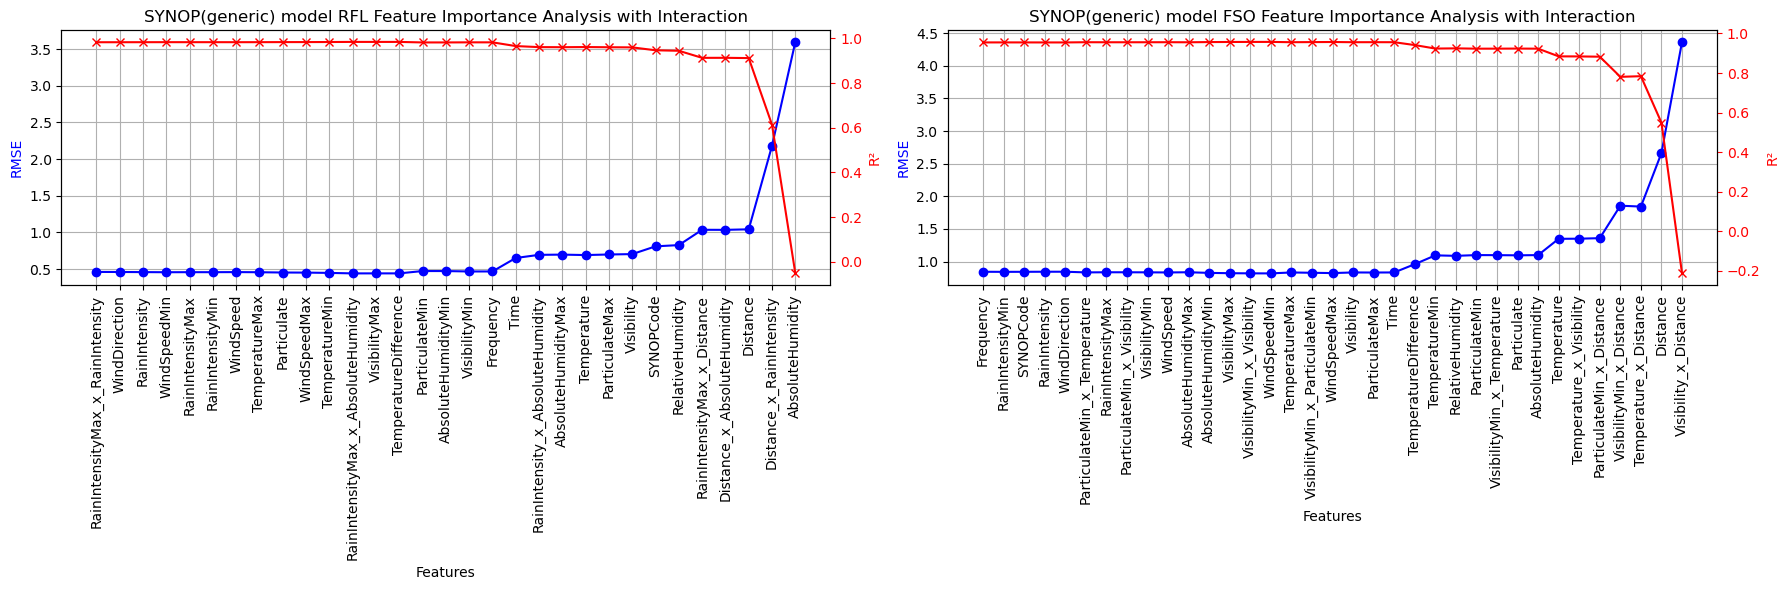

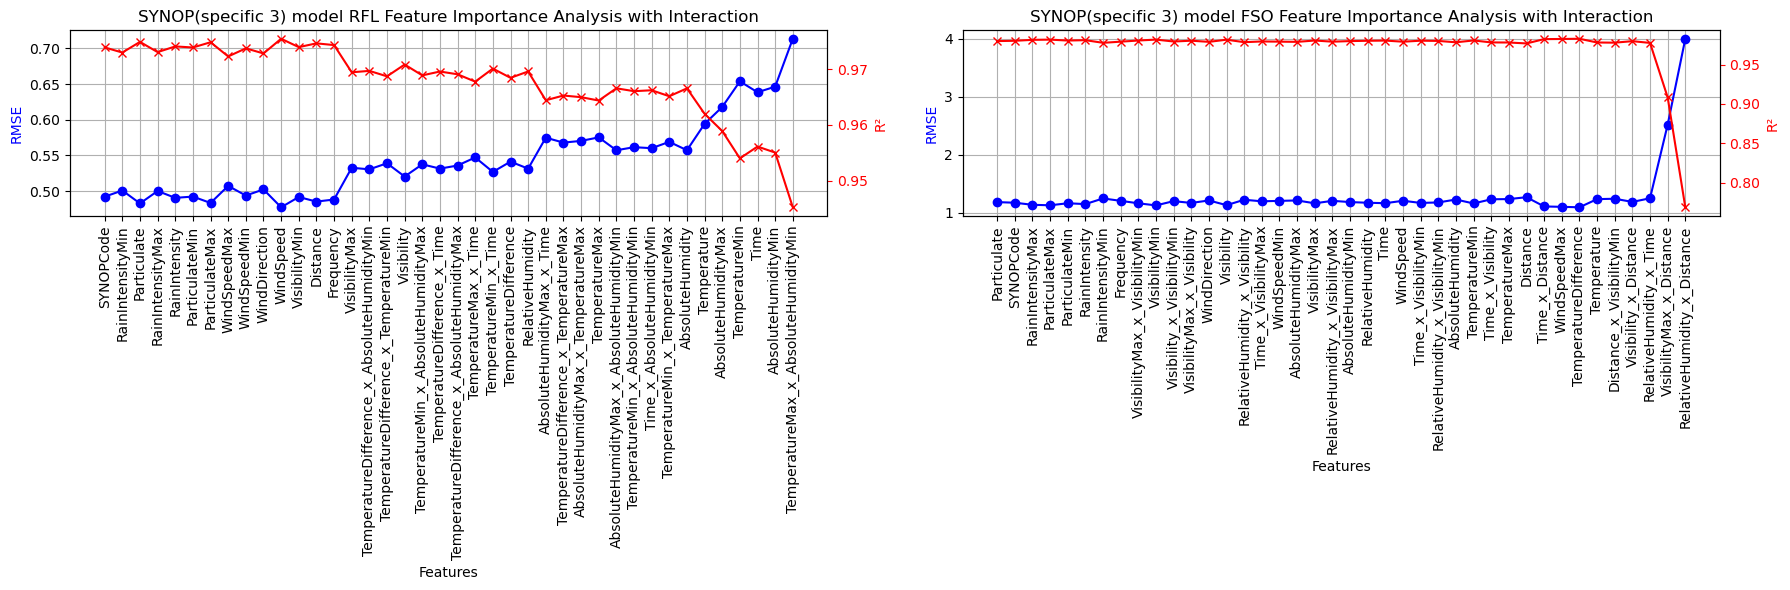

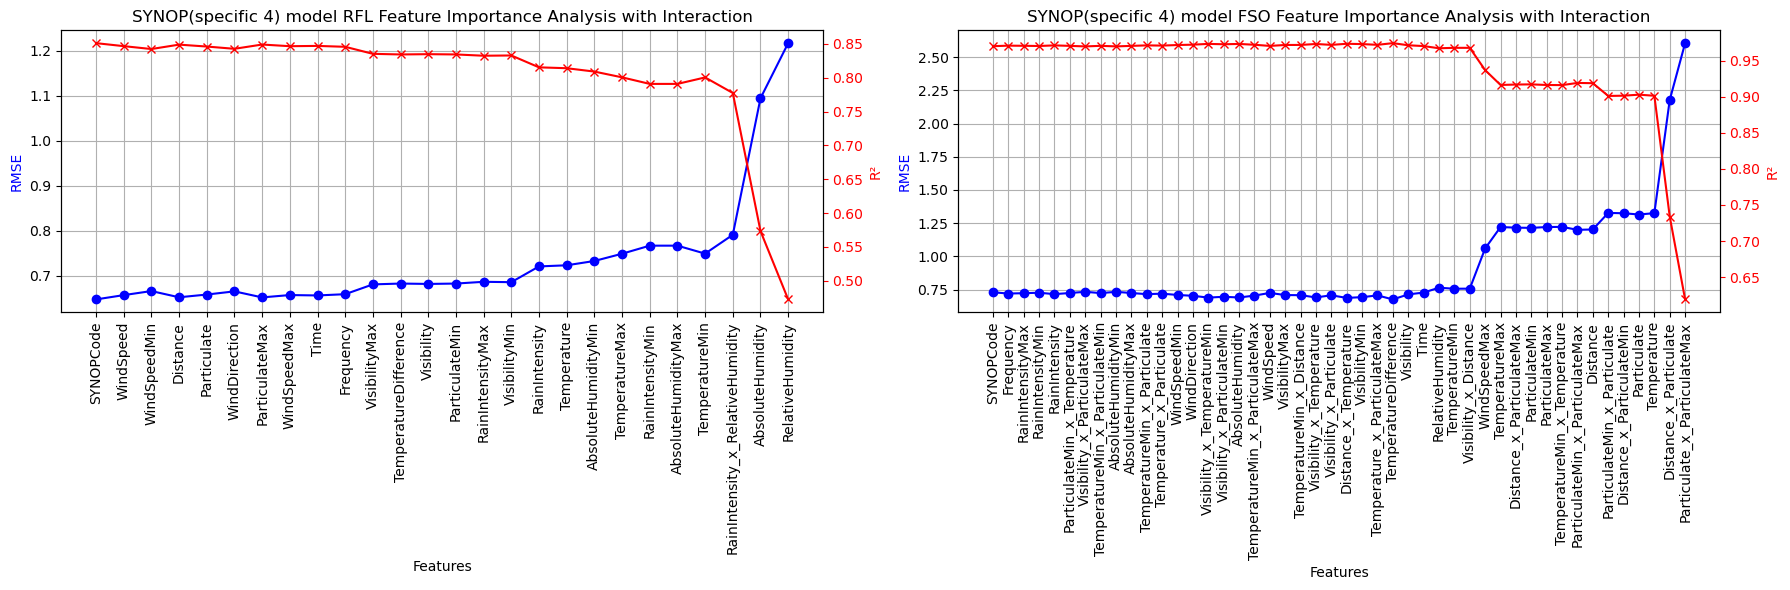

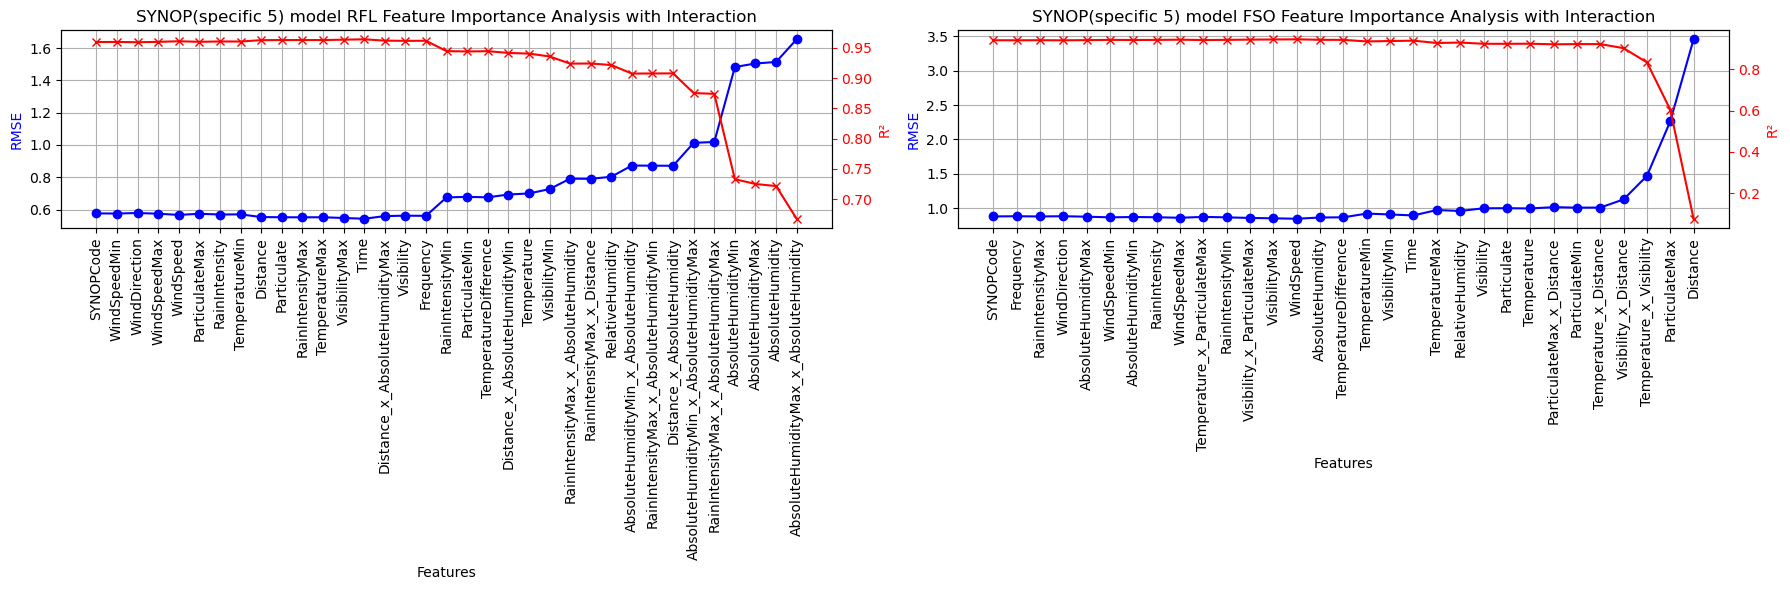

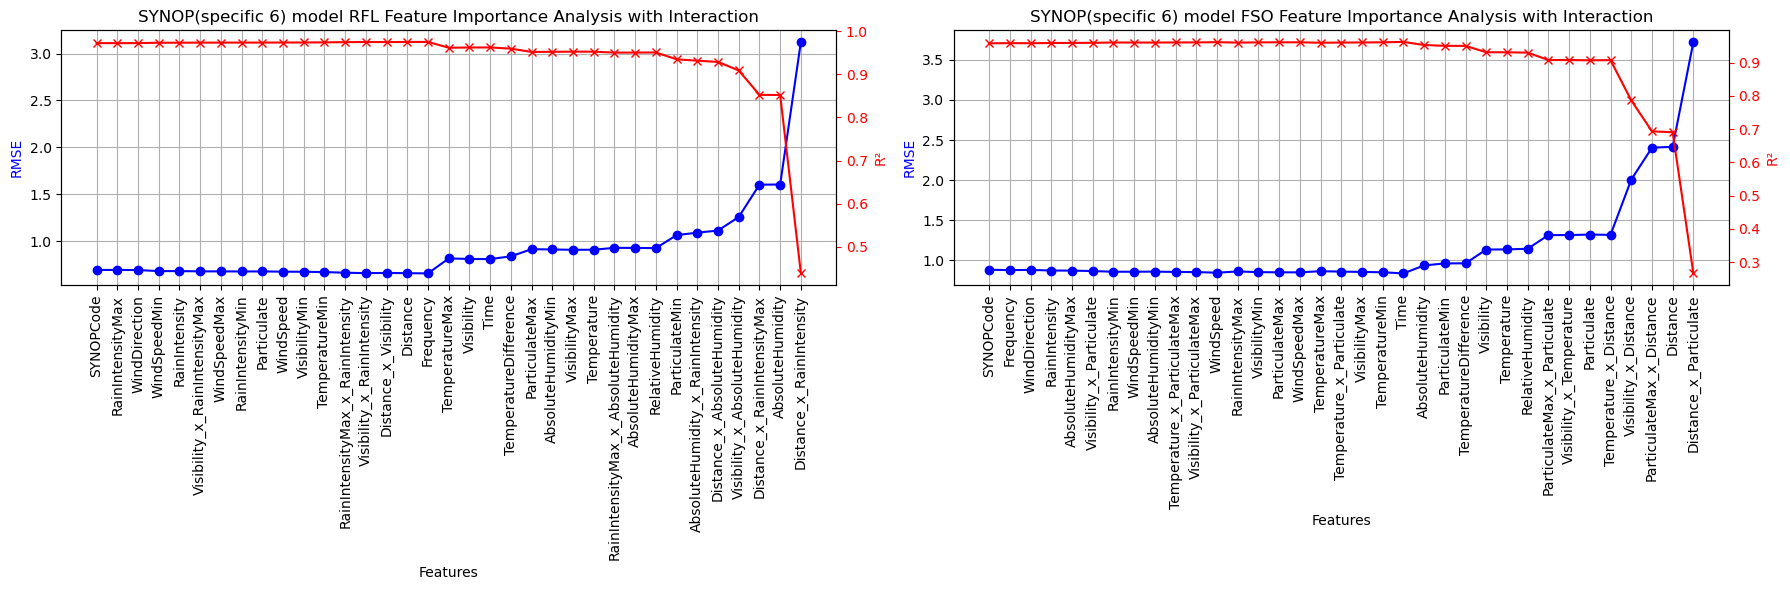

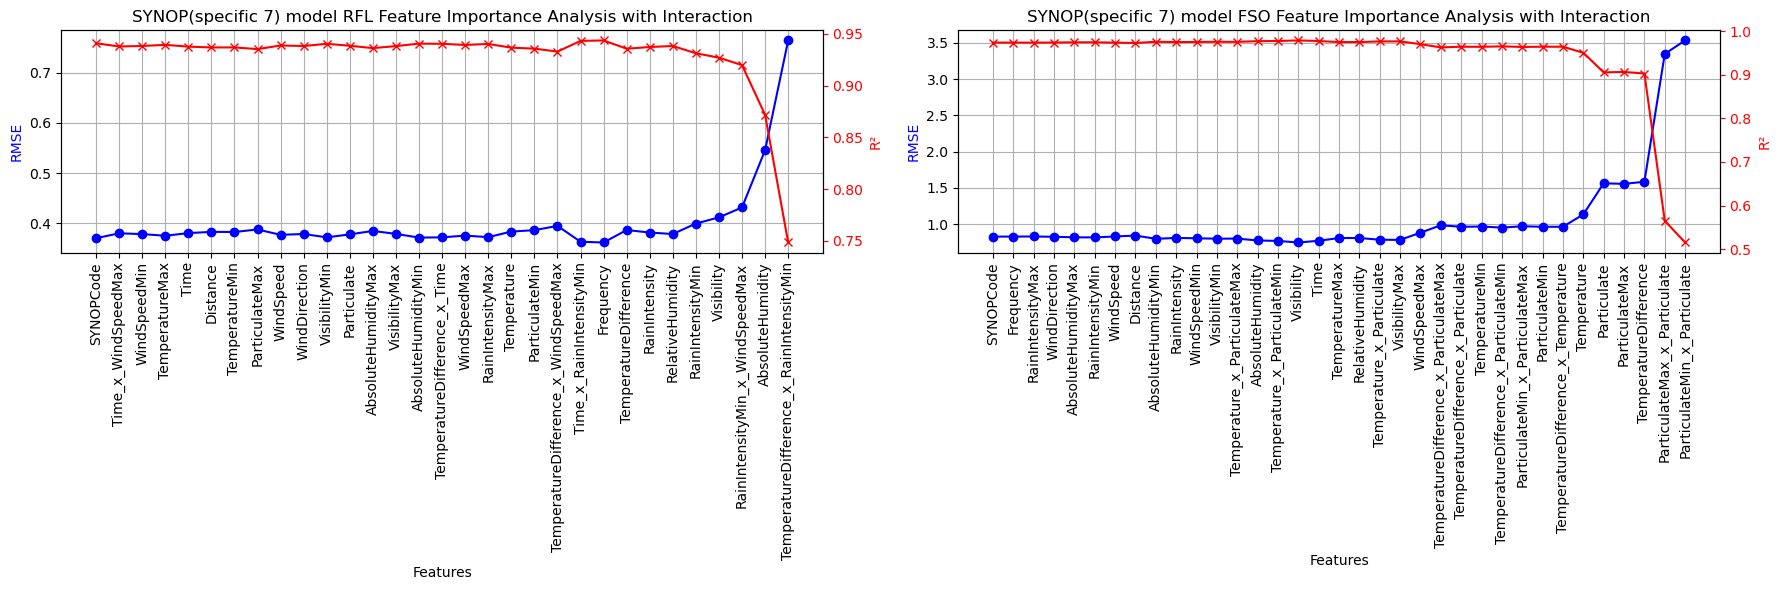

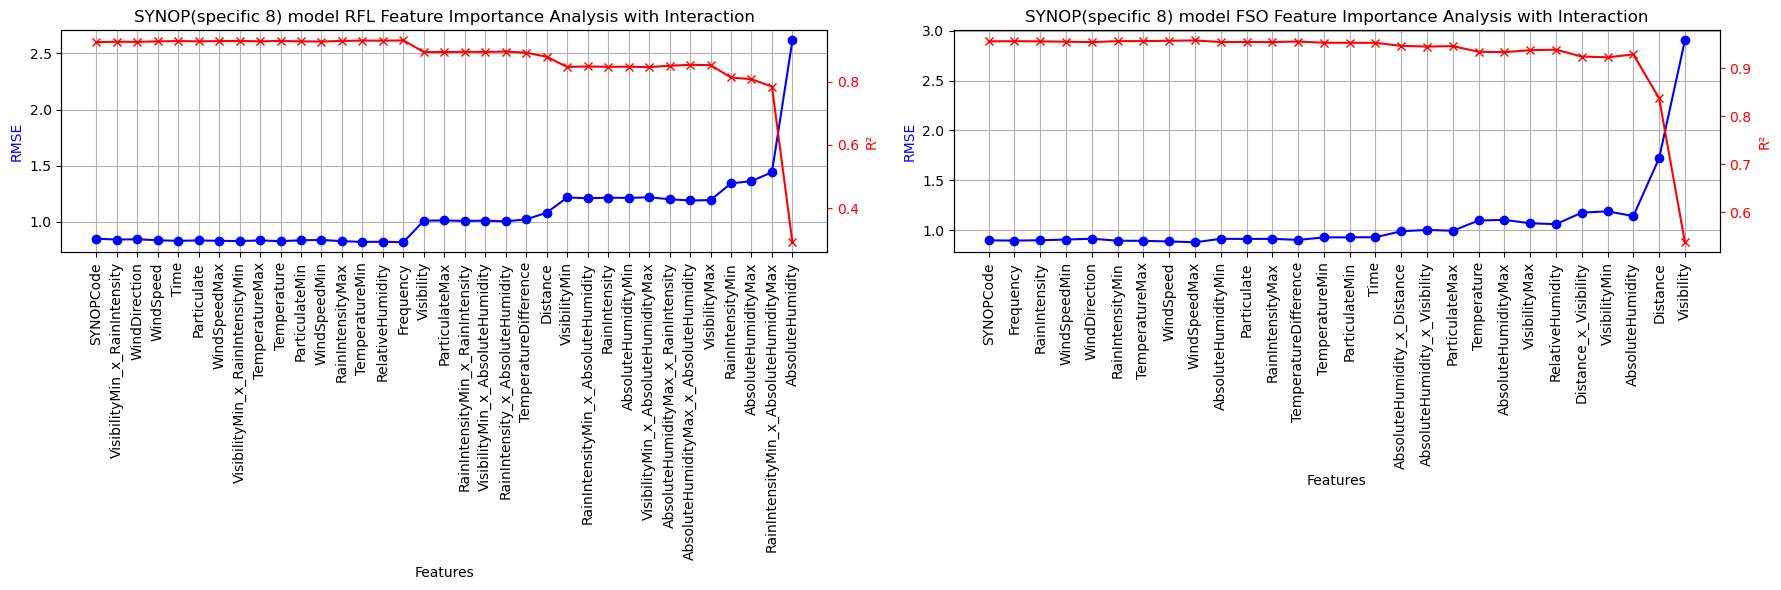

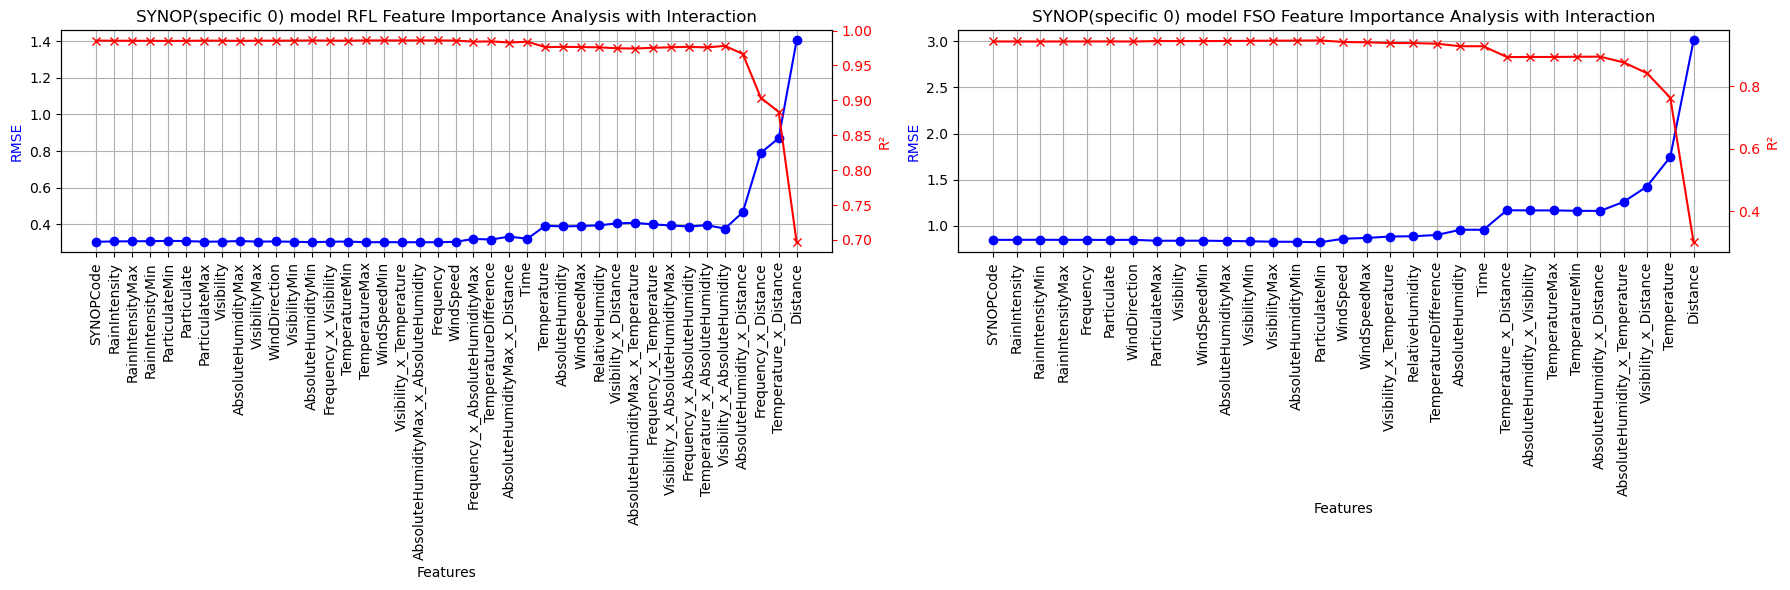

In [20]:
plot_results(g_result_RFL, g_result_FSO, 'generic')
plot_results(III_result_RFL, III_result_FSO, 'specific 3')
plot_results(IV_result_RFL, IV_result_FSO, 'specific 4')
plot_results(V_result_RFL, V_result_FSO, 'specific 5')
plot_results(VI_result_RFL, VI_result_FSO, 'specific 6')
plot_results(VII_result_RFL, VII_result_FSO, 'specific 7')
plot_results(VIII_result_RFL, VIII_result_FSO, 'specific 8')
plot_results(Zero_result_RFL, Zero_result_FSO, 'specific 0')